In [ ]:
# default_exp modeling.question_answering


In [ ]:
# all_slow


In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# modeling.question_answering

> This module contains custom models, loss functions, custom splitters, etc... for question answering tasks

In [ ]:
# export
import os, ast, inspect
from typing import Any, Callable, Dict, List, Optional, Union, Type

from fastcore.all import *
from fastai.callback.all import *
from fastai.data.block import DataBlock, CategoryBlock, ColReader, ItemGetter, ColSplitter, RandomSplitter
from fastai.data.core import DataLoader, DataLoaders, TfmdDL
from fastai.imports import *
from fastai.learner import *
from fastai.losses import CrossEntropyLossFlat
from fastai.optimizer import Adam, OptimWrapper, params
from fastai.torch_core import *
from fastai.torch_imports import *
from seqeval import metrics as seq_metrics
from transformers import AutoModelForQuestionAnswering, PreTrainedModel, logging

from blurr.utils import BLURR
from blurr.data.core import TextBlock, BlurrDataLoader, first_blurr_tfm
from blurr.modeling.core import BaseModelCallback, PreCalculatedLoss, Blearner
from blurr.data.question_answering import QAPreprocessor, QATextInput, QABatchTokenizeTransform

# metrics we'll use in extractive qa
from datasets import load_metric
squad_metric = load_metric("squad")

logging.set_verbosity_error()


In [ ]:
# hide_input
import pdb

from datasets import load_dataset
from fastai.data.external import untar_data, URLs
from fastcore.test import *
from nbdev.showdoc import show_doc
from transformers import AutoConfig

from blurr.utils import print_versions
from blurr.modeling.core import BaseModelWrapper, PreCalculatedLoss, blurr_splitter

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions("torch fastai transformers")


What we're running with at the time this documentation was generated:
torch: 1.10.1+cu111
fastai: 2.5.3
transformers: 4.16.2


In [ ]:
# hide
# cuda
torch.cuda.set_device(1)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")


Using GPU #1: GeForce GTX 1080 Ti


## Setup

We'll use a subset of `squad_v2` to demonstrate how to configure your blurr code for training extractive question answering models. See the `data.question_answering` module if any of this setting up of the `squad_df` below looks unfamiliar to you.

In [ ]:
raw_datasets = load_dataset("squad", split=["train[:1000]", "validation[:200]"])

raw_train_df = pd.DataFrame(raw_datasets[0])
raw_valid_df = pd.DataFrame(raw_datasets[1])

raw_train_df["is_valid"] = False
raw_valid_df["is_valid"] = True

squad_df = pd.concat([raw_train_df, raw_valid_df])

squad_df["ans_start_char_idx"] = squad_df.answers.apply(lambda v: v["answer_start"][0] if len(v["answer_start"]) > 0 else "0")
squad_df["answer_text"] = squad_df.answers.apply(lambda v: v["text"][0] if len(v["text"]) > 0 else "")
squad_df["ans_end_char_idx"] = squad_df["ans_start_char_idx"].astype(int) + squad_df["answer_text"].str.len()

print(len(squad_df))


Reusing dataset squad (/home/wgilliam/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)


  0%|          | 0/2 [00:00<?, ?it/s]

1200


In [ ]:
model_cls = AutoModelForQuestionAnswering

pretrained_model_name = "bert-large-uncased-whole-word-masking-finetuned-squad"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, model_cls=model_cls)

max_seq_len = 128
vocab = dict(enumerate(range(max_seq_len)))


In [ ]:
preprocessor = QAPreprocessor(
    hf_tokenizer, id_attr="id", tok_kwargs={"return_overflowing_tokens": True, "max_length": max_seq_len, "stride": 64}
)

proc_df = preprocessor.process_df(squad_df)
proc_df.head(1)


,id,title,context,question,answers,is_valid,ans_start_char_idx,answer_text,ans_end_char_idx,proc_question,proc_context,ans_start_token_idx,ans_end_token_idx,is_answerable
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct...",To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?,"{'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}",False,515,Saint Bernadette Soubirous,541,To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputed",0,0,False


In [ ]:
before_batch_tfm = QABatchTokenizeTransform(hf_arch, hf_config, hf_tokenizer, hf_model, max_length=max_seq_len)

blocks = (
    TextBlock(batch_tokenize_tfm=before_batch_tfm, input_return_type=QATextInput),
    CategoryBlock(vocab=vocab),
    CategoryBlock(vocab=vocab),
)

# since its preprocessed, we include an "text" key with the values of our question and context
def get_x(item):
    return {"text": (item.proc_question, item.proc_context), "id": item.id}


dblock = DataBlock(
    blocks=blocks,
    get_x=get_x,
    get_y=[ItemGetter("ans_start_token_idx"), ItemGetter("ans_end_token_idx")],
    splitter=ColSplitter(),
    n_inp=1,
)


In [ ]:
dls = dblock.dataloaders(proc_df, bs=4)


In [ ]:
len(dls.vocab), dls.vocab[0], dls.vocab[1]


(2,
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 1

In [ ]:
dls.valid.show_batch(dataloaders=dls, max_n=2)


,text,found,start/end,answer
0,"which nfl team represented the afc at super bowl 50? super bowl 50 was an american football game to determine the champion of the national football league ( nfl ) for the 2015 season. the american football conference ( afc ) champion denver broncos defeated the national football conference ( nfc ) champion carolina panthers 24 – 10 to earn their third super bowl title. the game was played on february 7, 2016, at levi's stadium in the san francisco bay area at santa clara, california. as this was the 50th super bowl, the league emphasized the "" golden anniversary "" with various gold - themed initiatives, as well as temporarily suspending the",True,"(46, 48)",denver broncos
1,"which nfl team represented the afc at super bowl 50? earn their third super bowl title. the game was played on february 7, 2016, at levi's stadium in the san francisco bay area at santa clara, california. as this was the 50th super bowl, the league emphasized the "" golden anniversary "" with various gold - themed initiatives, as well as temporarily suspending the tradition of naming each super bowl game with roman numerals ( under which the game would have been known as "" super bowl l "" ), so that the logo could prominently feature the arabic numerals 50.",False,"(0, 0)",


## Mid-level API

### `QAModelCallback`

Here we create a question/answer specific subclass of `BaseModelCallback` in order to get all the start and end prediction.

In [ ]:
# export
class QAModelCallback(BaseModelCallback):
    """The prediction is a combination start/end logits"""

    def after_pred(self):
        super().after_pred()
        self.learn.pred = (self.pred.start_logits, self.pred.end_logits)


### `QAMetricsCallback`

In [ ]:
# export
class QAMetricsCallback(Callback):
    def __init__(self, compute_metrics_func, validation_ds, qa_metrics=["exact_match", "f1"], **kwargs):
        self.run_before = Recorder

        store_attr()
        self.custom_metrics_dict = {k: None for k in qa_metrics}
        self.do_setup = True

    def setup(self):
        # one time setup code here.
        if not self.do_setup:
            return

        # grab the hf_tokenizer from the TokenClassBatchTokenizeTransform
        tfm = first_blurr_tfm(self.learn.dls, tfms=[QABatchTokenizeTransform])
        self.hf_tokenizer = tfm.hf_tokenizer
        self.tok_kwargs = tfm.tok_kwargs

        # add custom question answering specific metrics
        custom_metrics = L([ValueMetric(partial(self.metric_value, metric_key=k), k) for k in self.qa_metrics])
        self.learn.metrics = self.learn.metrics + custom_metrics

        self.do_setup = False

    def before_fit(self):
        self.setup()

    # --- batch before/after phases ---
    def before_batch(self):
        if self.training or self.learn.y is None:
            return

        self.batch_inputs = {k: v.cpu().detach().numpy() if isinstance(v, Tensor) else v for k, v in self.x.items()}

    def after_batch(self):
        if self.training or self.learn.y is None:
            return

        for i in range(len(self.batch_inputs["input_ids"])):
            batch_inps = {k: self.batch_inputs[k][i] for k in self.batch_inputs.keys()}
            self.results.append(
                {**batch_inps, "start_logits": self.pred[0][i].cpu().detach().numpy(), "end_logits": self.pred[1][i].cpu().detach().numpy()}
            )

    # --- validation begin/after phases ---
    def before_validate(self):
        self.results = []

    def after_validate(self):
        if len(self.results) < 1:
            return

        metric_vals_d = self.compute_metrics_func(self.results, self.validation_ds, self.hf_tokenizer, self.tok_kwargs)
        for k, v in metric_vals_d.items():
            self.custom_metrics_dict[k] = v

    # --- for ValueMetric metrics ---
    def metric_value(self, metric_key):
        return self.custom_metrics_dict[metric_key]


In [ ]:
#export
def compute_qa_metrics(results, dataset, hf_tokenizer, tok_kwargs, id_attr="id", n_best=20):
    # what is the max length for our inputs?
    max_length = tok_kwargs.get("max_length", hf_tokenizer.model_max_length)

    # map examples to chunks indicies that are part of the
    example_to_chunks = collections.defaultdict(list)
    for idx, chunk in enumerate(results):
        example_to_chunks[chunk[id_attr]].append(idx)

    predicted_answers = []
    for item_idx, item in enumerate(dataset):
        example_id = item[id_attr]

        answers = []
        for chunk_idx in example_to_chunks[example_id]:
            chunk = results[chunk_idx]
            input_ids = chunk["input_ids"]
            start_logits = chunk["start_logits"]
            end_logits = chunk["end_logits"]

            start_indexes = np.argsort(start_logits)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best - 1 : -1].tolist()

            for s_idx, start_index in enumerate(start_indexes):
                for e_idx, end_index in enumerate(end_indexes):
                    # Skip answers that are not fully in the context
                    if start_index == 0 and end_index == 0:
                        continue

                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if end_index < start_index or end_index - start_index + 1 > max_length:
                        continue

                    answer = {
                        "text": hf_tokenizer.decode(input_ids[start_index:end_index], skip_special_tokens=True),
                        "logit_score": start_logits[start_index] + end_logits[end_index],
                    }
                    answers.append(answer)

        # select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append({"id": example_id, "prediction_text": best_answer["text"]})
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    ref_answers = [{"id": item["id"], "answers": item["answers"]} for item_idx, item in enumerate(dataset)]

    metric_vals_d = squad_metric.compute(predictions=predicted_answers, references=ref_answers)
    return metric_vals_d


### `PreCalculatedQALoss`

Hugging Face question answering models will calculate the loss for you when you include both the `start_positions` and `end_positions` in the inputs dictionary.  This is done by the `QABatchTokenizeTransform` when `include_labels` = True (which is the default).  This also requires fastai developers to set their `Learner`'s loss function to the `PreCalculatedQALoss` for training to work properly.

In [ ]:
#export
class PreCalculatedQALoss(PreCalculatedLoss):
    def __init__(self, *args, axis=-1, **kwargs): 
        super().__init__(nn.CrossEntropyLoss, *args, axis=axis, **kwargs)

    def __call__(self, inp, targ, targ2, **kwargs):
        return tensor(0.0)

    def decodes(self, x):
        return x[0].argmax(dim=self.axis), x[1].argmax(dim=self.axis)

    def activation(self, x):
        return F.softmax(x[0], dim=self.axis), F.softmax(x[1], dim=self.axis)


### `MultiTargetLoss`

If you want more control over the loss calculation, we provide here a custom loss function you can use in your question answering tasks.

In fact, this new loss function can be used in many other multi-modal architectures, with any mix of loss functions.  For example, this can be ammended to include the `is_impossible` task, as well as the start/end token tasks in the SQUAD v2 dataset.

In [ ]:
# export
class MultiTargetLoss(Module):
    """Provides the ability to apply different loss functions to multi-modal targets/predictions"""

    def __init__(
        self,
        # The loss function for each target
        loss_classes: List[Callable] = [CrossEntropyLossFlat, CrossEntropyLossFlat],
        # Any kwargs you want to pass to the loss functions above
        loss_classes_kwargs: List[dict] = [{}, {}],
        # The weights you want to apply to each loss (default: [1,1])
        weights: Union[List[float], List[int]] = [1, 1],
        # The `reduction` parameter of the lass function (default: 'mean')
        reduction: str = "mean",
    ):
        loss_funcs = [cls(reduction=reduction, **kwargs) for cls, kwargs in zip(loss_classes, loss_classes_kwargs)]
        store_attr(self=self, names="loss_funcs, weights")
        self._reduction = reduction

    # custom loss function must have either a reduction attribute or a reduction argument (like all fastai and
    # PyTorch loss functions) so that the framework can change this as needed (e.g., when doing lear.get_preds
    # it will set = 'none'). see this forum topic for more info: https://bit.ly/3br2Syz
    @property
    def reduction(self):
        return self._reduction

    @reduction.setter
    def reduction(self, v):
        self._reduction = v
        for lf in self.loss_funcs:
            lf.reduction = v

    def forward(self, outputs, *targets):
        loss = 0.0
        for i, loss_func, weights, output, target in zip(range(len(outputs)), self.loss_funcs, self.weights, outputs, targets):
            loss += weights * loss_func(output, target)

        return loss

    def activation(self, outs):
        acts = [self.loss_funcs[i].activation(o) for i, o in enumerate(outs)]
        return acts

    def decodes(self, outs):
        decodes = [self.loss_funcs[i].decodes(o) for i, o in enumerate(outs)]
        return decodes


### Example

Notice below how I had to define the loss function *after* creating the `Learner` object.  I'm not sure why, but the `MultiTargetLoss` above prohibits the learner from being exported if I do.

#### Training

In [ ]:
model = BaseModelWrapper(hf_model)
learn_cbs = [QAModelCallback]

validation_ds = proc_df[proc_df.is_valid == True].to_dict(orient="records")
fit_cbs = [QAMetricsCallback(compute_metrics_func=compute_qa_metrics, validation_ds=validation_ds)]

learn = Learner(dls, model, opt_func=partial(Adam), cbs=learn_cbs, splitter=blurr_splitter)

learn.loss_func = PreCalculatedQALoss() #MultiTargetLoss()
learn.create_opt()  # -> will create your layer groups based on your "splitter" function
learn.freeze()


In [ ]:
# hide_output
# learn.summary()


In [ ]:
print(len(learn.opt.param_groups))


3


SuggestedLRs(minimum=0.0033113110810518267, steep=6.309573450380412e-07, valley=0.0006918309954926372, slide=0.0004786300996784121)

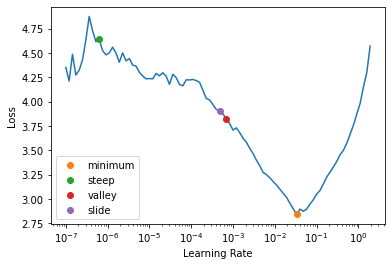

In [ ]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])


In [ ]:
learn.fit_one_cycle(1, lr_max=1e-3, cbs=fit_cbs)


epoch,train_loss,valid_loss,exact_match,f1,time
0,0.999888,1.125377,83.606557,89.794859,01:29


#### Showing results

And here we create a `@typedispatch`ed implementation of `Learner.show_results` for a more intuitive QA task

In [ ]:
# export
@typedispatch
def show_results(
    # This typedispatched `show_results` will be called for `QuestionAnswerTextInput` typed inputs
    x: QATextInput,
    # The targets
    y,
    # Your raw inputs/targets
    samples,
    # The model's predictions
    outs,
    # Your `Learner`. This is required so as to get at the Hugging Face objects for decoding them into
    # something understandable
    learner,
    # Whether you want to remove special tokens during decoding/showing the outputs
    skip_special_tokens=True,
    # Your `show_results` context
    ctxs=None,
    # The maximum number of items to show
    max_n=6,
    # Any truncation your want applied to your decoded inputs
    trunc_at=None,
    # Any other keyword arguments you want applied to `show_results`
    **kwargs
):
    tfm = first_blurr_tfm(learner.dls, tfms=[QABatchTokenizeTransform])
    hf_tokenizer = tfm.hf_tokenizer

    res = L()
    for sample, input_ids, start, end, pred in zip(samples, x, *y, outs):
        txt = hf_tokenizer.decode(sample[0], skip_special_tokens=True)[:trunc_at]
        found = start.item() != 0 and end.item() != 0
        ans_text = hf_tokenizer.decode(input_ids[start:end], skip_special_tokens=False)

        pred_ans_toks = hf_tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=False)[int(pred[0]) : int(pred[1])]
        pred_ans_txt = hf_tokenizer.convert_tokens_to_string(pred_ans_toks)

        res.append((txt, found, (start.item(), end.item()), ans_text, (int(pred[0]), int(pred[1])), pred_ans_txt))

    display_df(pd.DataFrame(res, columns=["text", "found", "start/end", "answer", "pred start/end", "pred answer"]))
    return ctxs


In [ ]:
learn.show_results(learner=learn, skip_special_tokens=True, max_n=4, trunc_at=500)


,text,found,start/end,answer,pred start/end,pred answer
0,"which nfl team represented the afc at super bowl 50? super bowl 50 was an american football game to determine the champion of the national football league ( nfl ) for the 2015 season. the american football conference ( afc ) champion denver broncos defeated the national football conference ( nfc ) champion carolina panthers 24 – 10 to earn their third super bowl title. the game was played on february 7, 2016, at levi's stadium in the san francisco bay area at santa clara, california. as this was",True,"(46, 48)",denver broncos,"(46, 48)",denver broncos
1,"how many nfl teams have had only one loss by the end of a regular season? for the third straight season, the number one seeds from both conferences met in the super bowl. the carolina panthers became one of only ten teams to have completed a regular season with only one loss, and one of only six teams to have acquired a 15 – 1 record, while the denver broncos became one of four teams to have made eight appearances in the super bowl. the broncos made their second super bowl appearance in three ye",True,"(45, 46)",ten,"(45, 46)",ten
2,"who was the 2015 nfl mvp? the panthers finished the regular season with a 15 – 1 record, and quarterback cam newton was named the nfl most valuable player ( mvp ). they defeated the arizona cardinals 49 – 15 in the nfc championship game and advanced to their second super bowl appearance since the franchise was founded in 1995. the broncos finished the regular season with a 12 – 4 record, and denied the new england patriots a chance to defend their title from super bowl xlix by defeating them 20",True,"(24, 26)",cam newton,"(24, 26)",cam newton
3,"how many nfl teams have finished the regular season with one loss? for the third straight season, the number one seeds from both conferences met in the super bowl. the carolina panthers became one of only ten teams to have completed a regular season with only one loss, and one of only six teams to have acquired a 15 – 1 record, while the denver broncos became one of four teams to have made eight appearances in the super bowl. the broncos made their second super bowl appearance in three years, ha",True,"(41, 42)",ten,"(41, 42)",ten


In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1, lr_max=slice(1e-9, 1e-7), cbs=fit_cbs)

epoch,train_loss,valid_loss,exact_match,f1,time
0,0.961219,1.123544,82.950820,89.122922,03:08


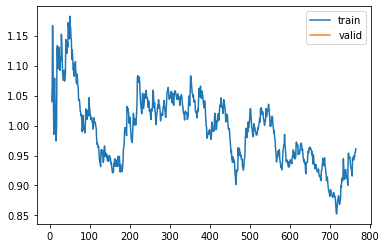

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(learner=learn, max_n=2, trunc_at=100)

,text,found,start/end,answer,pred start/end,pred answer
0,which nfl team represented the afc at super bowl 50? super bowl 50 was an american football game to,True,"(46, 48)",denver broncos,"(46, 48)",denver broncos
1,who is the quarterback for the panthers? founded in 1995. the broncos finished the regular season wi,False,"(0, 0)",,"(9, 9)",


#### Prediction

Note that there is a bug currently in fastai v2 (or with how I'm assembling everything) that currently prevents us from seeing the decoded predictions and probabilities for the "end" token.

In [ ]:
# export
@patch
def blurr_predict_answers(
    self: Learner,
    # The str (or list of strings) you want to get token classification predictions for
    question_contexts: Union[dict, List[dict]],
    # If using a slow tokenizer, users will need to prove a `slow_word_ids_func` that accepts a
    # tokenizzer, example index, and a batch encoding as arguments and in turn returnes the
    # equavlient of fast tokenizer's `word_ids``
    slow_word_ids_func: Optional[Callable] = None,
):
    if not is_listy(question_contexts):
        question_contexts = [question_contexts]

    tfm = first_blurr_tfm(self.dls, tfms=[QABatchTokenizeTransform])
    hf_tokenizer = tfm.hf_tokenizer
    tok_kwargs = tfm.tok_kwargs
    tok_kwargs["return_overflowing_tokens"] = True
    tok_kwargs["truncation"] = "only_second" if hf_tokenizer.padding_side == "right" else "only_first"

    results = []
    for qc in question_contexts:
        inps = [qc["question"], qc["context"]] if hf_tokenizer.padding_side == "right" else [qc["context"], qc["question"]]

        inputs = hf_tokenizer(*inps, max_length=tfm.max_length, padding=tfm.padding, return_tensors="pt", **tok_kwargs)
        inputs_offsets = inputs["offset_mapping"]

        # run inputs through model
        model_inputs = {k: v.to(self.model.hf_model.device) for k, v in inputs.items()}
        outputs = self.model(model_inputs)

        # grab our start/end logits
        start_logits = outputs.start_logits
        end_logits = outputs.end_logits

        # mask any tokens that shouldn't be considered
        seq_ids = inputs.sequence_ids()
        # mask question tokens
        ignore_mask = [i != 1 if hf_tokenizer.padding_side == "right" else i != 0 for i in seq_ids]
        # unmask the [CLS] token
        ignore_mask[0] = False
        # mask all the [PAD] tokens
        ignore_mask = torch.logical_or(torch.tensor(ignore_mask)[None], (inputs["attention_mask"] == 0))

        start_logits[ignore_mask] = tfm.ignore_token_id
        end_logits[ignore_mask] = tfm.ignore_token_id

        # grab our start/end probabilities
        start_probs = F.softmax(start_logits, dim=-1)
        end_probs = F.softmax(end_logits, dim=-1)

        # get scores for each chunk
        candidates = []
        for offset_idx, (chunk_start_probs, chunk_end_probs) in enumerate(zip(start_probs, end_probs)):
            scores = chunk_start_probs[:, None] * chunk_end_probs[None, :]
            idx = torch.triu(scores).argmax().item()

            start_idx = idx // scores.shape[0]
            end_idx = idx % scores.shape[0]
            score = scores[start_idx, end_idx].item()
            candidates.append((offset_idx, start_idx, end_idx, score))

        # sort our candidates by score
        candidates.sort(key=lambda el: el[3], reverse=True)

        # return our best answer
        best = candidates[0]
        if best[1] == 0 and best[2] == 0:
            results.append({"answer": None, "start": 0, "end": 0, "score": best[3]})
        else:
            start_char_idx = inputs_offsets[best[0]][best[1]][0]
            end_char_idx = inputs_offsets[best[0]][best[2] - 1][1]
            ans = inps[1][start_char_idx:end_char_idx].strip()

            results.append({"answer": ans, "start": start_char_idx.item(), "end": end_char_idx.item(), "score": best[3]})

    # build our results
    return results


In [ ]:
context = "George Lucas created Star Wars in 1977. He directed and produced it."

learn.blurr_predict_answers({"question": "What did George Lucas make?", "context": context})


[{'answer': 'Star Wars', 'start': 21, 'end': 30, 'score': 0.9490354657173157}]

In [ ]:
context = "George Lucas created Star Wars in 1977. He directed and produced it."

learn.blurr_predict_answers([
    {"question": "What did George Lucas make?", "context": context},
    {"question": "What year did Star Wars come out?", "context": context},
    {"question": "What did George Lucas do?", "context": context},
    {"question": "Who plays Spock in the movie?", "context": context},
])

[{'answer': 'Star Wars', 'start': 21, 'end': 30, 'score': 0.9490354657173157},
 {'answer': '1977', 'start': 34, 'end': 38, 'score': 0.9435020685195923},
 {'answer': 'directed and produced it',
  'start': 43,
  'end': 67,
  'score': 0.3867945373058319},
 {'answer': 'George Lucas',
  'start': 0,
  'end': 12,
  'score': 0.46773701906204224}]

#### Inference

Note that I had to replace the loss function because of the above-mentioned issue to exporting the model with the `MultiTargetLoss` loss function.  After getting our inference learner, we put it back and we're good to go!

In [ ]:
export_name = "q_and_a_learn_export"


In [ ]:
learn.loss_func = CrossEntropyLossFlat()
learn.export(fname=f"{export_name}.pkl")


In [ ]:
inf_learn = load_learner(fname=f"{export_name}.pkl")
inf_learn.loss_func = MultiTargetLoss()

context = "George Lucas created Star Wars in 1977. He directed and produced it."

inf_learn.blurr_predict_answers([
    {"question": "What did George Lucas make?", "context": context},
    {"question": "What year did Star Wars come out?", "context": context},
    {"question": "What did George Lucas do?", "context": context},
    {"question": "Who plays Spock in the movie?", "context": context},
])


[{'answer': 'Star Wars', 'start': 21, 'end': 30, 'score': 0.9490355849266052},
 {'answer': '1977', 'start': 34, 'end': 38, 'score': 0.9435020685195923},
 {'answer': 'directed and produced it',
  'start': 43,
  'end': 67,
  'score': 0.3867940902709961},
 {'answer': 'George Lucas',
  'start': 0,
  'end': 12,
  'score': 0.46773818135261536}]

In [ ]:
# hide
try:
    del learn
    del inf_learn
    torch.cuda.empty_cache()
except:
    pass


## The High-level API

### `BLearnerForQuestionAnswering`

In [ ]:
# export
@delegates(Blearner.__init__)
class BlearnerForQuestionAnswering(Blearner):
    def __init__(self, dls: DataLoaders, hf_model: PreTrainedModel, **kwargs):
        kwargs["loss_func"] = kwargs.get("loss_func", PreCalculatedQALoss())
        super().__init__(dls, hf_model, base_model_cb=QAModelCallback, **kwargs)

    @classmethod
    def get_model_cls(self):
        return AutoModelForQuestionAnswering

    @classmethod
    def _get_x(cls, x, qst, ctx, id=None, padding_side="right"):
        inps = {}
        inps["text"] = (x[qst], x[ctx]) if (padding_side == "right") else (x[ctx], x[qst])

        if id is not None:
            inps["id"] = x[id]

        return inps

    @classmethod
    def from_data(
        cls,
        # Your raw dataset. Supports DataFrames, Hugging Face Datasets, as well as file paths 
        # to .csv, .xlsx, .xls, and .jsonl files
        data: Union[pd.DataFrame, Path, str, List[Dict]],
        # The name or path of the pretrained model you want to fine-tune
        pretrained_model_name_or_path: Optional[Union[str, os.PathLike]],
        # The maximum sequence length to constrain our data
        max_seq_len: int = None,
        # The unique identifier in the dataset. If not specified and "return_overflowing_tokens": True, an "_id" attribute
        # will be added to your dataset with its value a unique, sequential integer, assigned to each record
        id_attr: Optional[str] = None,
        # The attribute in your dataset that contains the context (where the answer is included) (default: 'context')
        context_attr: str = "context",
        # The attribute in your dataset that contains the question being asked (default: 'question')
        question_attr: str = "question",
        # The attribute in your dataset that contains the tokenized answer start (default: 'tok_answer_start')
        tok_ans_start_attr: str = "ans_start_token_idx",
        # The attribute in your dataset that contains the tokenized answer end(default: 'tok_answer_end')
        tok_ans_end_attr: str = "ans_end_token_idx",
        # A function that will split your Dataset into a training and validation set
        # See [here](https://docs.fast.ai/data.transforms.html#Split) for a list of fast.ai splitters
        dblock_splitter: Optional[Callable] = None,
        # Any kwargs to pass to your `DataLoaders`
        dl_kwargs={},
        # Any kwargs to pass to your task specific `Blearner`
        learner_kwargs={},
    ):
        # if we get a path/str then we're loading something like a .csv file
        if isinstance(data, Path) or isinstance(data, str):
            content_type = mimetypes.guess_type(data)[0]
            if content_type  == 'application/vnd.openxmlformats-officedocument.spreadsheetml.sheet': 
                data = pd.read_excel(data)
            elif content_type  == 'text/csv': 
                data = pd.read_csv(data)
            elif content_type  == 'application/json': 
                data = pd.read_json(data, orient='records')
            else: 
                raise ValueError("'data' must be a .xlsx, .xls, .csv, or .jsonl file")

            data = pd.read_csv(data)

        # infer our datablock splitter if None
        if dblock_splitter is None:
            dblock_splitter = ColSplitter() if hasattr(data, "is_valid") else RandomSplitter()

        hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name_or_path, model_cls=cls.get_model_cls())

        # potentially used by our preprocess_func, it is the basis for our CategoryBlock vocab
        if max_seq_len is None:
            max_seq_len = hf_config.get("max_position_embeddings", 128)

        # bits required by our "before_batch_tfm" and DataBlock
        vocab = list(range(max_seq_len))
        padding_side = hf_tokenizer.padding_side

        # define DataBlock and DataLoaders
        before_batch_tfm = QABatchTokenizeTransform(hf_arch, hf_config, hf_tokenizer, hf_model, max_length=max_seq_len)
        blocks = (
            TextBlock(batch_tokenize_tfm=before_batch_tfm, input_return_type=QATextInput),
            CategoryBlock(vocab=vocab),
            CategoryBlock(vocab=vocab),
        )
        dblock = DataBlock(
            blocks=blocks, 
            get_x=partial(cls._get_x, qst=question_attr, ctx=context_attr, id=id_attr, padding_side=padding_side), 
            get_y=[ItemGetter(tok_ans_start_attr), ItemGetter(tok_ans_end_attr)],
            splitter=dblock_splitter, 
            n_inp=1)

        dls = dblock.dataloaders(data, **dl_kwargs.copy())

        # return BLearner instance
        return cls(dls, hf_model, **learner_kwargs.copy())

### Example

`BLearnerForQuestionAnswering` requires a question, context (within which to find the answer to the question), and the start/end indices of where the answer lies in the *tokenized context*. Because those indices vary by tokenizer, we can pass a `preprocess_func` that will take our raw data, perform any preprocessing we want, and return it in a way that will work for extractive QA.

#### Preprocess data

In [ ]:
# build our training and validation DataFrames
raw_datasets = load_dataset("squad", split=["train[:1000]", "validation[:200]"])

raw_train_df = pd.DataFrame(raw_datasets[0])
raw_valid_df = pd.DataFrame(raw_datasets[1])

raw_train_df["is_valid"] = False
raw_valid_df["is_valid"] = True

# concatenate into a single DataFrame
squad_df = pd.concat([raw_train_df, raw_valid_df])

# include the required start/end character indicies and full text of the answer
squad_df["ans_start_char_idx"] = squad_df.answers.apply(lambda v: v["answer_start"][0] if len(v["answer_start"]) > 0 else "0")
squad_df["answer_text"] = squad_df.answers.apply(lambda v: v["text"][0] if len(v["text"]) > 0 else "")
squad_df["ans_end_char_idx"] = squad_df["ans_start_char_idx"].astype(int) + squad_df["answer_text"].str.len()

# run our modified DataFrame thru the QAPreprocessor to get the start/end "token" indices we want to predict
preprocessor = QAPreprocessor(
    hf_tokenizer, id_attr="id", tok_kwargs={"return_overflowing_tokens": True, "max_length": max_seq_len, "stride": 64}
)

proc_df = preprocessor.process_df(squad_df)
proc_df.head(1)

Reusing dataset squad (/home/wgilliam/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)


  0%|          | 0/2 [00:00<?, ?it/s]

,id,title,context,question,answers,is_valid,ans_start_char_idx,answer_text,ans_end_char_idx,proc_question,proc_context,ans_start_token_idx,ans_end_token_idx,is_answerable
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct...",To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?,"{'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}",False,515,Saint Bernadette Soubirous,541,To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?,"Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend ""Venite Ad Me Omnes"". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputed",0,0,False


#### Define your `Blearner`

In [ ]:
pretrained_model_name = "bert-large-uncased-whole-word-masking-finetuned-squad"

learn = BlearnerForQuestionAnswering.from_data(
    proc_df,
    pretrained_model_name,
    id_attr="id",
    question_attr="proc_question",
    context_attr="proc_context",
    max_seq_len=128,
    dl_kwargs={"bs": 4},
).to_fp16()

validation_ds = proc_df[proc_df.is_valid == True].to_dict(orient="records")
fit_cbs = [QAMetricsCallback(compute_metrics_func=compute_qa_metrics, validation_ds=validation_ds)]


In [ ]:
learn.dls.show_batch(dataloaders=learn.dls, max_n=4, trunc_at=500)


,text,found,start/end,answer
0,"with what institute did notre dame agree to an exchange program in the 1960s? ism. "" thomas blantz, c. s. c., notre dame's vice president of student affairs, added that coeducation "" opened up a whole other pool of very bright students. "" two of the male residence halls were converted for the newly admitted female students that first year, while two others were converted for the next school year. in 1971 mary ann proctor became the first female undergraduate ; she transferred from st. mary's col",False,"(0, 0)",
1,"what is the name of the house of dereon junior collection? eon, a respected seamstress. according to tina, the overall style of the line best reflects her and beyonce's taste and style. beyonce and her mother founded their family's company beyond productions, which provides the licensing and brand management for house of dereon, and its junior collection, dereon. house of dereon pieces were exhibited in destiny's child's shows and tours, during their destiny fulfilled era. the collection feature",True,"(76, 79)",dereon.
2,"how many ncaa tournaments did the notre dame men's basketball team take part in? they advanced to the semifinals but were beaten by penn state who went on and beat baylor in the championship. the 2010 – 11 team concluded its regular season ranked number seven in the country, with a record of 25 – 5, brey's fifth straight 20 - win season, and a second - place finish in the big east. during the 2014 - 15 season, the team went 32 - 6 and won the acc conference tournament, later advancing to the eli",False,"(0, 0)",
3,"what is beyonce's net worth in 2015? in 2013, beyonce's endorsements of pepsi and h & m made her and jay z the world's first billion dollar couple in the music industry. that year, beyonce was published as the fourth most - powerful celebrity in the forbes rankings. mtv estimated that by the end of 2014, beyonce would become the highest - paid black musician in history ; she succeeded to do so in april 2014. in june 2014, beyonce ranked at # 1 on the forbes celebrity 100 list, earning an estimat",False,"(0, 0)",


#### Train

In [ ]:
validation_ds = proc_df[proc_df.is_valid == True].to_dict(orient="records")
fit_cbs = [QAMetricsCallback(compute_metrics_func=compute_qa_metrics, validation_ds=validation_ds)]

learn.fit_one_cycle(3, lr_max=1e-3, cbs=fit_cbs)


epoch,train_loss,valid_loss,exact_match,f1,time
0,0.612134,0.987003,74.426230,86.476262,01:50
1,0.503770,0.925693,79.672131,86.815420,01:50
2,0.288923,1.020977,83.606557,87.848118,01:51


In [ ]:
learn.show_results(learner=learn, skip_special_tokens=True, max_n=2, trunc_at=500)


,text,found,start/end,answer,pred start/end,pred answer
0,"which nfl team represented the afc at super bowl 50? super bowl 50 was an american football game to determine the champion of the national football league ( nfl ) for the 2015 season. the american football conference ( afc ) champion denver broncos defeated the national football conference ( nfc ) champion carolina panthers 24 – 10 to earn their third super bowl title. the game was played on february 7, 2016, at levi's stadium in the san francisco bay area at santa clara, california. as this was",True,"(46, 48)",denver broncos,"(46, 48)",denver broncos
1,"what stadium did super bowl 50 take place in? super bowl 50 was an american football game to determine the champion of the national football league ( nfl ) for the 2015 season. the american football conference ( afc ) champion denver broncos defeated the national football conference ( nfc ) champion carolina panthers 24 – 10 to earn their third super bowl title. the game was played on february 7, 2016, at levi's stadium in the san francisco bay area at santa clara, california. as this was the 50",True,"(80, 84)",levi's stadium,"(80, 84)",levi's stadium


#### Inference

In [ ]:
learn = learn.to_fp32()
learn.loss_func = CrossEntropyLossFlat()
learn.export(fname=f"{export_name}.pkl")


In [ ]:
inf_learn = load_learner(fname=f"{export_name}.pkl")
inf_learn.loss_func = MultiTargetLoss()

context = "George Lucas created Star Wars in 1977. He directed and produced it."

inf_learn.blurr_predict_answers([
    {"question": "What did George Lucas make?", "context": context},
    {"question": "What year did Star Wars come out?", "context": context},
    {"question": "What did George Lucas do?", "context": context},
    {"question": "Who plays Spock in the movie?", "context": context},
])

[{'answer': 'Star Wars', 'start': 21, 'end': 30, 'score': 0.9941784143447876},
 {'answer': '1977', 'start': 34, 'end': 38, 'score': 0.6654327511787415},
 {'answer': 'directed and produced it',
  'start': 43,
  'end': 67,
  'score': 0.3628372848033905},
 {'answer': None, 'start': 0, 'end': 0, 'score': 0.4101639986038208}]

## Summary

This module includes all the low, mid, and high-level API bits for extractive Q&A tasks training and inference.

In [ ]:
# hide
from nbdev.export import notebook2script

notebook2script()


Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01_modeling-core.ipynb.
Converted 02_data-language-modeling.ipynb.
Converted 02_modeling-language-modeling.ipynb.
Converted 03_data-token-classification.ipynb.
Converted 03_modeling-token-classification.ipynb.
Converted 04_data-question-answering.ipynb.
Converted 04_modeling-question-answering.ipynb.
Converted 10_data-seq2seq-core.ipynb.
Converted 10_modeling-seq2seq-core.ipynb.
Converted 11_data-seq2seq-summarization.ipynb.
Converted 11_modeling-seq2seq-summarization.ipynb.
Converted 12_data-seq2seq-translation.ipynb.
Converted 12_modeling-seq2seq-translation.ipynb.
Converted 99a_examples-high-level-api.ipynb.
Converted 99b_examples-glue.ipynb.
Converted 99c_examples-glue-plain-pytorch.ipynb.
Converted 99d_examples-multilabel.ipynb.
Converted 99e_examples-causal-lm-gpt2.ipynb.
Converted index.ipynb.
